In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.models as models
from torchvision.utils import draw_keypoints
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

import os

from PIL import Image

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

from scipy.spatial.distance import cdist

from IPython import display

c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
img_path = 'mpii_human_pose_v1/images'

In [4]:
data = pd.read_csv('var_8.csv')
data.head()

,Unnamed: 0,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,5523,5524,063704755.jpg,-1,-1,-1,-1,262,382,372,...,158,345,120,458,222,440,300,3.964942,child care,home activities
1,5524,5525,027401178.jpg,-1,-1,758,652,814,494,772,...,203,822,253,762,420,680,398,4.267008,child care,home activities
2,5525,5526,031484116.jpg,998,578,950,466,948,237,923,...,187,712,282,725,421,698,503,3.970169,child care,home activities
3,5526,5527,011680411.jpg,772,611,807,468,888,286,872,...,197,776,197,779,350,721,439,3.940826,child care,home activities
4,5527,5528,027315962.jpg,-1,-1,426,478,419,351,440,...,197,466,209,455,316,371,335,2.402998,child care,home activities


In [5]:
data = data.drop('Unnamed: 0', axis = 1)
data.head()

,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,5524,063704755.jpg,-1,-1,-1,-1,262,382,372,376,...,158,345,120,458,222,440,300,3.964942,child care,home activities
1,5525,027401178.jpg,-1,-1,758,652,814,494,772,494,...,203,822,253,762,420,680,398,4.267008,child care,home activities
2,5526,031484116.jpg,998,578,950,466,948,237,923,299,...,187,712,282,725,421,698,503,3.970169,child care,home activities
3,5527,011680411.jpg,772,611,807,468,888,286,872,303,...,197,776,197,779,350,721,439,3.940826,child care,home activities
4,5528,027315962.jpg,-1,-1,426,478,419,351,440,354,...,197,466,209,455,316,371,335,2.402998,child care,home activities


In [12]:
def draw_points(points, image, ax):    
    ax.imshow(image)

    keypoints_x = points[::2]
    keypoints_y = points[1::2]
    for i in range(len(keypoints_x)):
        ax.scatter(keypoints_x[i], keypoints_y[i], color='red', marker='o')

    ax.plot(keypoints_x[:3],keypoints_y[:3],color='blue')
    ax.plot(keypoints_x[3:6],keypoints_y[3:6],color='blue')
    ax.plot(keypoints_x[-6:-3],keypoints_y[-6:-3],color='blue')
    ax.plot(keypoints_x[-3:],keypoints_y[-3:],color='blue')
    ax.plot(keypoints_x[6:10],keypoints_y[6:10],color='blue')
    
    ax.plot([keypoints_x[-4]]+[keypoints_x[7]]+[keypoints_x[-3]],[keypoints_y[-4]]+[keypoints_y[7]]+[keypoints_y[-3]],color='blue')
    ax.plot([keypoints_x[2]]+[keypoints_x[6]]+[keypoints_x[3]],[keypoints_y[2]]+[keypoints_y[6]]+[keypoints_y[3]],color='blue')

    ax.axis('off')

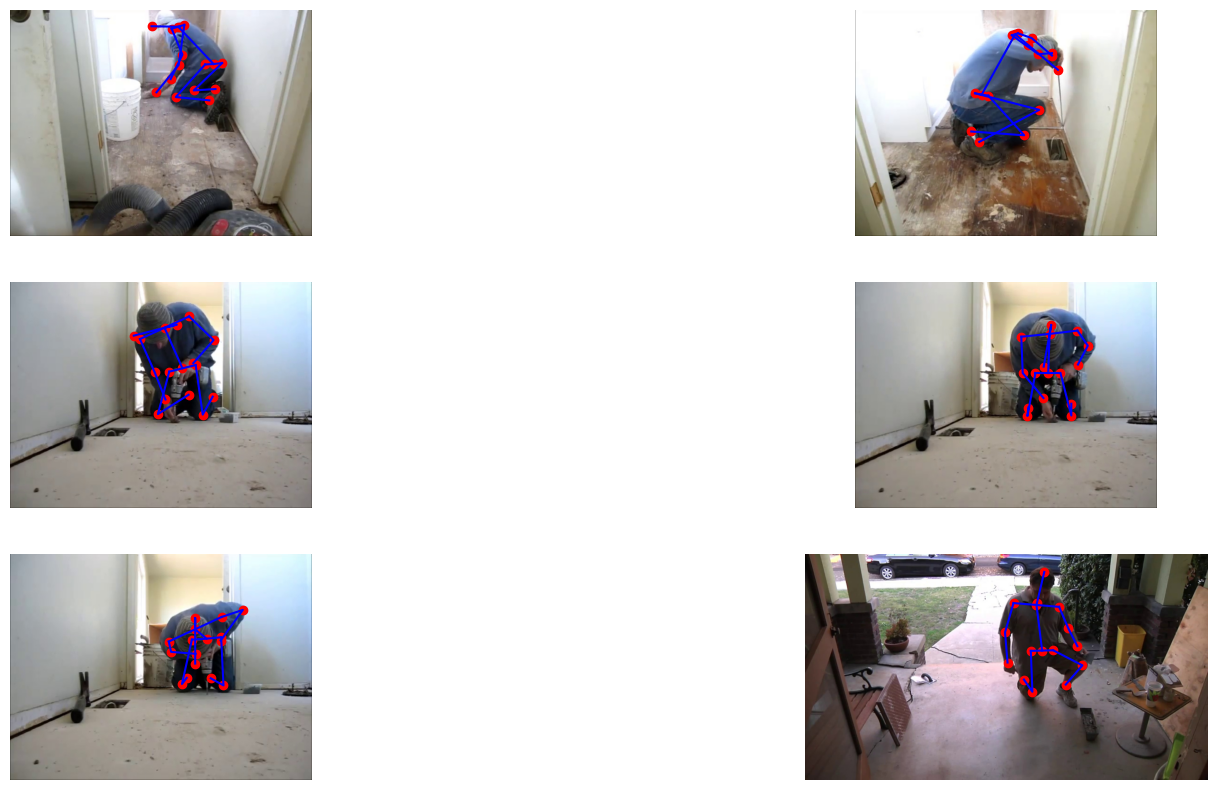

In [13]:
fig, axs = plt.subplots(3,2, figsize =(20,10))
idx = 0
for _, row in data[38:44].iterrows():
    name = row.values[1]

    pts = row.values[2:34]
    im = Image.open(img_path+'/'+name)
    idx += 1
    draw_points(pts, im, axs[(idx-1)//2][(idx-1)%2])
plt.show()

In [14]:
transform = transforms.Compose([
    transforms.Resize(size = (256,256)),
    transforms.ToTensor()
])

In [15]:
X_data = []
Y_data = []
sizes = []
for _, row in data.iterrows():
    name = row.values[1]
    points = row.values[2:34]
    img = Image.open(img_path+'/'+name)
    sizes += [img.size]
    for i in range(len(points)//2):
        points[2*i] = points[2*i]*260//img.size[0]
        points[2*i+1] = points[2*i+1]*260//img.size[1]
    X_data += [transform(img)]
    Y_data += [points]
X_data = torch.stack(X_data, dim = 0)

### Для нахождения точек будем использовать resnet50, однако она предсказывает 17 точек, а нам надо 16. Поэтому после предсказаний надо будет превратить 17 точек в 16.

In [17]:
resnet_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

In [18]:
resnet_model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [19]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    _, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TTF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

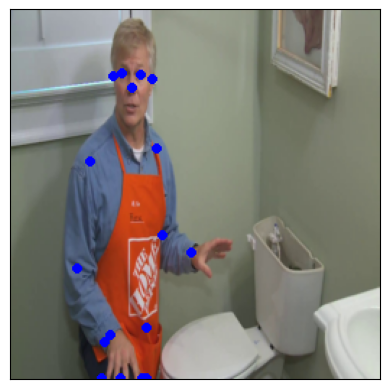

In [21]:
idx = 16
keypoints = resnet_model([X_data[idx]])[0]['keypoints'][:1]
res = draw_keypoints((X_data[idx]*255).type(torch.uint8), keypoints, colors="blue", radius=3)
show(res)

In [24]:
preds = []
for i in range(len(X_data)):
    if i % 10 == 0:
        print(i)
    pred = resnet_model([X_data[i]])[0]['keypoints'][0]
    preds += [[]]
    for point in pred:
        preds[i] += [float(point[0])]
        preds[i] += [float(point[1])]

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780


### Чтобы получить из 17 точек 16 будем использовать обычную нейросеть из одного линейного слоя. Но чтобы её можно было обучить, придётся создать несколько даталоадеров.

In [74]:
x_train, x_test, y_train, y_test = train_test_split(preds, Y_data, test_size=0.2, random_state=52)
xx_train, xx_test, yy_train, yy_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=52)

train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train).float(),torch.Tensor(y_train).float())
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test).float(), torch.Tensor(y_test).float())

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

ttrain_dataset = torch.utils.data.TensorDataset(torch.Tensor(xx_train).float(),torch.Tensor(yy_train).float())
ttest_dataset = torch.utils.data.TensorDataset(torch.Tensor(xx_test).float(), torch.Tensor(yy_test).float())

ttrain_dataloader = torch.utils.data.DataLoader(ttrain_dataset, batch_size=16, shuffle=True)
ttest_dataloader = torch.utils.data.DataLoader(ttest_dataset, batch_size=16, shuffle=False)

tttest_dataset = torch.utils.data.TensorDataset(torch.Tensor(xx_test).float(), torch.Tensor(yy_test).float())

tttest_dataloader = torch.utils.data.DataLoader(ttest_dataset, batch_size=16, shuffle=True)

In [75]:
def train_net(net, optimizer, n_epoch, criterion, device):
    loss_history = []    
    train_loss = []    
    val_loss = []

    for i in range(n_epoch):
        epoch_loss = 0
        for x_batch, y_batch in train_dataloader:

            # Forward
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            predictions = net(x_batch)
            loss = criterion(predictions, y_batch)
            epoch_loss+=loss.item()*x_batch.shape[0]
            # Backward
            loss.backward()
            
            # Update weights
            optimizer.step()
            optimizer.zero_grad()

            loss_history.append(loss.item())
            
        train_loss.append(epoch_loss/len(train_dataset))
        epoch_loss = 0
        
        
        for x_batch, y_batch in test_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = net(x_batch)
            loss = criterion(predictions, y_batch)
            epoch_loss+=loss.item()*x_batch.shape[0]
        val_loss.append(epoch_loss/len(test_dataset))        
        
        # Visualize
        display.clear_output(wait=True)
        fig, axs = plt.subplots(1,2,figsize = (14,7))
        axs[0].plot(loss_history)
        axs[1].plot(train_loss, color = 'red')
        axs[1].plot(val_loss, color = 'green')

        plt.show()

        print('Current loss: %f' % loss)
    
    net.to(device)  
    return net

In [76]:
net = nn.Sequential(
    nn.Linear(34, 32)
)

In [77]:
n_epoch = 300
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.L1Loss()

In [78]:
net.to(device)

Sequential(
  (0): Linear(in_features=34, out_features=32, bias=True)
)

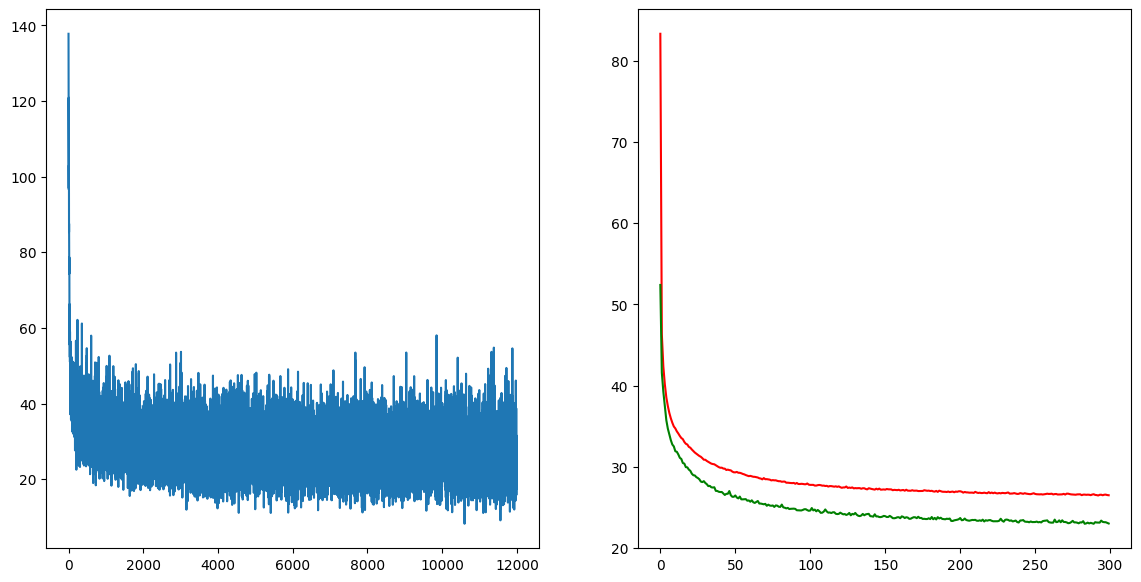

Current loss: 18.628384


In [79]:
net = train_net(net, optimizer, n_epoch, criterion, device)

In [91]:
tr = transforms.ToPILImage()
im_transform = transforms.Compose(
    [transforms.Normalize(mean=0, std=1)]
)

idx_to_show = 4

def show_people(net, test_dataloader, train_dataloader):
    fig, axs = plt.subplots(2,2,figsize = (20,10))
    axs[0][0].set_title('train')
    net.to('cpu')  
    for x_batch, y_batch in test_dataloader:
        # print(x_batch)
        preds = []
        for i in range(idx_to_show):
            pred = resnet_model([im_transform(x_batch[i])])[0]['keypoints'][0]
            preds.append([])
            for point in pred:
                preds[i].append(float(point[0]))
                preds[i].append(float(point[1]))
        predictions = net(torch.Tensor(preds).float())
        for j in range(idx_to_show):
            draw_points(predictions[j].detach().numpy(), tr(x_batch[j]), axs[j//2][j%2])
        break
    return

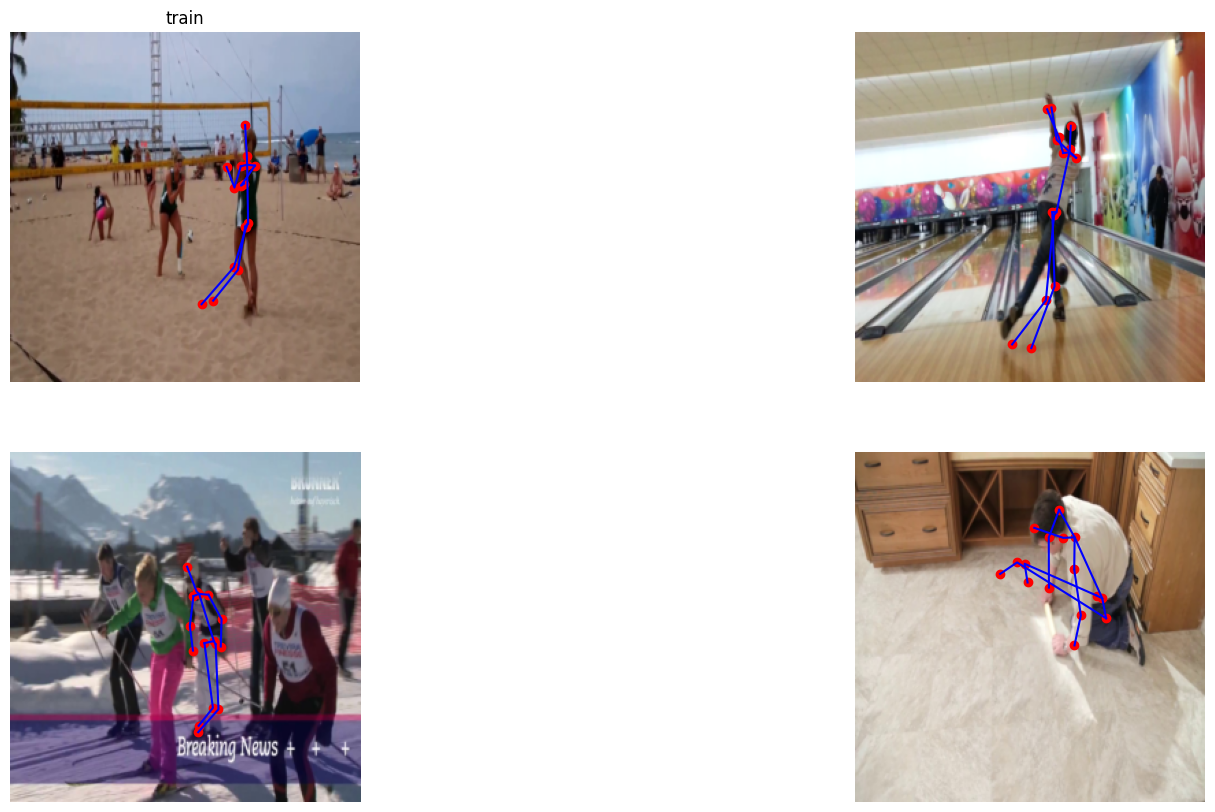

In [92]:
show_people(net, tttest_dataloader, train_dataloader)